In [101]:
!hydromt update sfincs ./semarang_sfincs_150 -o ./semarang_sfincs_pluvial -i sfincs_update_pluvial_semarang.ini -vv --dd

2022-07-12 09:23:33,702 - update - log - DEBUG - Appending log messages to file C:\Users\ampolini\Workingfolder\hydromt_sfincs-main\examples\semarang_sfincs_pluvial\hydromt.log.
2022-07-12 09:23:33,703 - update - log - INFO - HydroMT version: 0.4.5
2022-07-12 09:23:33,703 - update - main - INFO - Updating sfincs model at C:\Users\ampolini\Workingfolder\hydromt_sfincs-main\examples\semarang_sfincs_150 (r).
2022-07-12 09:23:33,703 - update - main - INFO - Output dir: C:\Users\ampolini\Workingfolder\hydromt_sfincs-main\examples\semarang_sfincs_pluvial
2022-07-12 09:23:33,704 - update - main - INFO - User settings:
2022-07-12 09:23:33,733 - update - model_plugins - DEBUG - Loaded model plugin 'sfincs = hydromt_sfincs.sfincs.SfincsModel' (0.2.1)
2022-07-12 09:23:33,734 - update - model_api - INFO - Initializing sfincs model from hydromt_sfincs (v0.2.1).
2022-07-12 09:23:33,734 - update - data_adapter - INFO - Adding deltares_data v0.0.6 sources from https://github.com/DirkEilander/hydromt-a

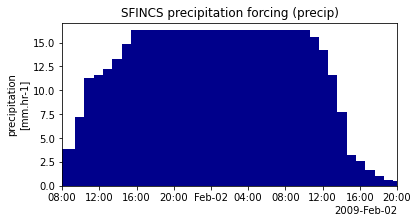

In [102]:
%matplotlib inline
from hydromt_sfincs import SfincsModel
import matplotlib.pyplot as plt
mod = SfincsModel(root="semarang_sfincs_pluvial", mode="r")
mod.forcing.pop('bzs', None)  # let's focus on precip for now
_ = mod.plot_forcing()

In [103]:
sfincs_root = "semarang_sfincs_pluvial"  # (relative) path to sfincs root
mod = SfincsModel(sfincs_root, mode="r", deltares_data= True)

Overwriting data source dtu10mdt_egm96.
Overwriting data source era5_hourly.
Overwriting data source gcn250.
Overwriting data source gebco.
Overwriting data source merit_hydro.
Overwriting data source osm_coastlines.
Overwriting data source vito.


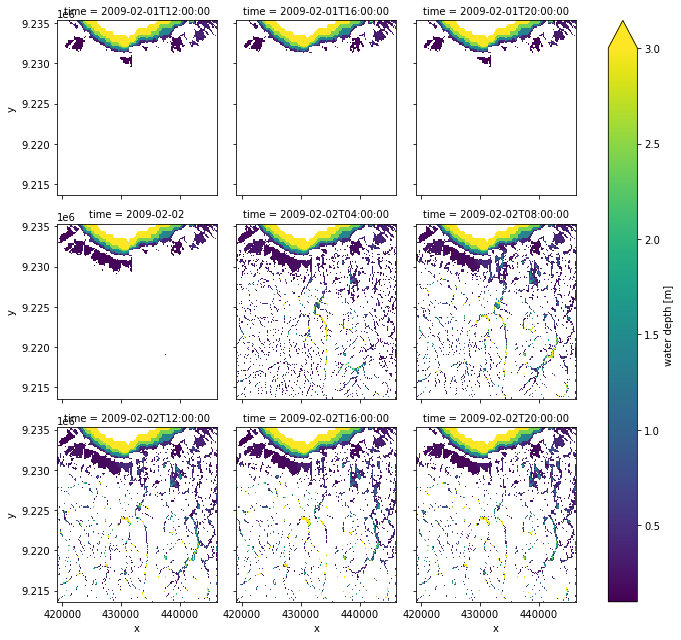

In [104]:
# h from sfincs_map contains the water depths for each cell face
# here we plot the water level every 4th hour

h = mod.results["h"].where(mod.results["h"] > 0.1)
h.attrs.update(long_name="water depth", unit="m")
h.sel(time=h["time"].values[4::4]).plot(col="time", col_wrap=3, vmax=3)

In [105]:
sfincs_root = "semarang_sfincs_pluvial"  # (relative) path to sfincs root
mod = SfincsModel(sfincs_root, mode="r", deltares_data= True)

Overwriting data source dtu10mdt_egm96.
Overwriting data source era5_hourly.
Overwriting data source gcn250.
Overwriting data source gebco.
Overwriting data source merit_hydro.
Overwriting data source osm_coastlines.
Overwriting data source vito.


In [106]:
# import dependencies
import xarray as xr
import numpy as np
from os.path import join
import matplotlib.pyplot as plt
import hydromt
from hydromt_sfincs import SfincsModel

In [107]:
hmax = mod.results['hmax']
hmax = hmax.reindex(y=list(reversed(hmax['y'].values))) # change orientation to N -> S
hmax.raster.to_raster(join(mod.root, 'gis', 'hmax.tif'), compress='LZW')

In [108]:
print(mod.data_catalog["gswo"])
gswo = mod.data_catalog.get_rasterdataset("gswo", buffer=10)
# permanent water where water occurence > 5%
gswo_mask = gswo.raster.reproject_like(mod.staticmaps, method="max") <= 3

{'category': 'hydrography',
 'data_type': 'RasterDataset',
 'driver': 'raster',
 'paper_doi': '10.1038/nature20584',
 'paper_ref': 'Pekel et al. (2016)',
 'path': 'p:\\wflow_global\\hydromt\\hydrography\\gswo\\occur.vrt',
 'source_url': 'https://global-surface-water.appspot.com/download',
 'source_version': 'v1_1_2019'}


nodata value missing for p:\wflow_global\hydromt\hydrography\gswo\occur.vrt


In [109]:
hmin = 0.10  # minimum flood depth [m] to plot
da_hmax = mod.results["hmax"]  # hmax is computed from zsmax - zb
# get overland flood depth with GSWO and set minimum flood depth
da_hmax_fld = da_hmax.where(gswo_mask).where(da_hmax > hmin)
# update attributes for colorbar label later
da_hmax.attrs.update(long_name="flood depth", unit="m")

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


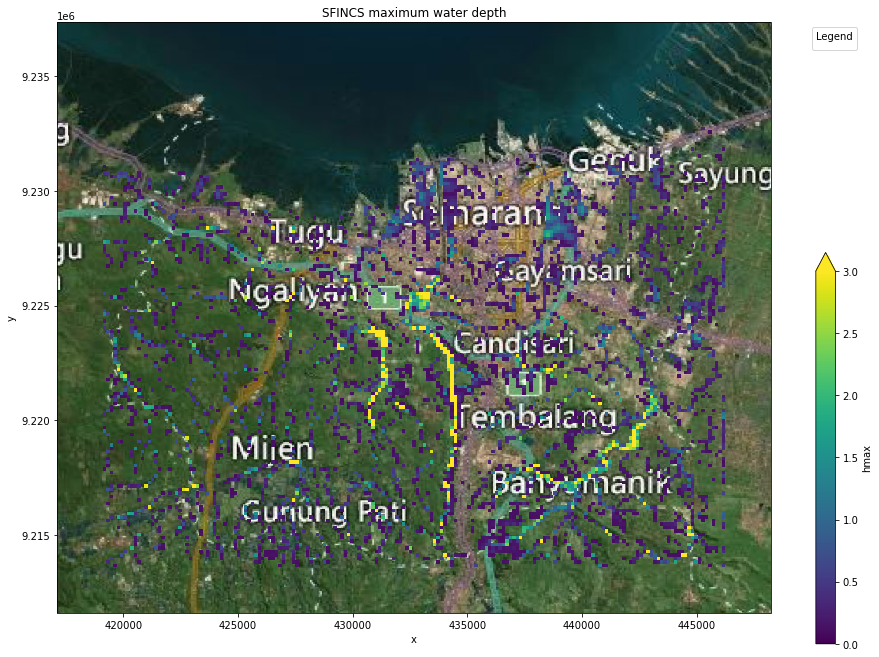

In [110]:
# create hmax plot and save to mod.root/figs/hmax.png
fig, ax = mod.plot_basemap(
    fn_out=None,
    variable=None,
    bmap="sat",
    geoms=["src", "obs"],
    plot_bounds=False,
    figsize=(16, 12),
)
# plot overland flooding based on gswo mask and mimum flood depth
cbar_kwargs = {"shrink": 0.6, "anchor": (0, 0)}
cax_fld = da_hmax_fld.plot(
    ax=ax, vmin=0, vmax=3.0, cmap=plt.cm.viridis, cbar_kwargs=cbar_kwargs
)

ax.set_title(f"SFINCS maximum water depth")
plt.savefig(join(mod.root, 'figs', 'hmax.png'), dpi=225, bbox_inches="tight")

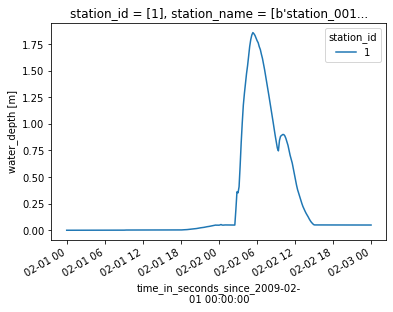

In [37]:
# point_h contains the water depths at the sfincs.obs gauge locations
# see mod.plot_basemaps (or next figure) for the location of the observation points
# make sure that the point ore not negative
h_point = mod.results["point_h"].rename({"stations": "station_id"})
h_point["station_id"] = h_point["station_id"].astype(int)
_ = h_point.plot.line(
    x="time",
)
plt.savefig(join(mod.root, 'figs', 'spatial_ref.png'), dpi=225, bbox_inches="tight")

In [38]:
import pandas as pd
h_df = h_point.reset_coords(drop=True).to_dataframe().unstack()
pd.set_option ('display.max_rows', None)
h_df.columns =  h_point['station_id'].values
h_df[1]>0.1

time
2009-02-01 00:00:00.000000000    False
2009-02-01 00:10:17.948120117    False
2009-02-01 00:20:27.502319335    False
2009-02-01 00:30:33.696655273    False
2009-02-01 00:40:38.673339843    False
2009-02-01 00:50:43.519287109    False
2009-02-01 01:00:44.832275390    False
2009-02-01 01:10:49.952636718    False
2009-02-01 01:20:55.145507812    False
2009-02-01 01:30:56.038085937    False
2009-02-01 01:41:01.227539062    False
2009-02-01 01:51:06.427246093    False
2009-02-01 02:01:07.244628906    False
2009-02-01 02:11:12.442871093    False
2009-02-01 02:21:17.641601562    False
2009-02-01 02:31:18.450195312    False
2009-02-01 02:41:23.632812500    False
2009-02-01 02:51:28.845703125    False
2009-02-01 03:01:29.660156250    False
2009-02-01 03:11:34.856445312    False
2009-02-01 03:21:40.063476562    False
2009-02-01 03:31:40.865234375    False
2009-02-01 03:41:46.065429687    False
2009-02-01 03:51:51.276367187    False
2009-02-01 04:01:52.073242187    False
2009-02-01 04:11:57.

In [39]:
import numpy as np 
from numpy import trapz
import matplotlib.pyplot as plt

In [77]:
def area_under_curve(depth):
    depth_time = trapz(depth, dx = 1)
    return depth_time

In [94]:
h_processed=h_point.to_series()

h_processed2=h_processed.reset_index(level='station_id')
h_processed2.index

DatetimeIndex([          '2009-02-01 00:00:00',
               '2009-02-01 00:10:17.948120117',
               '2009-02-01 00:20:27.502319335',
               '2009-02-01 00:30:33.696655273',
               '2009-02-01 00:40:38.673339843',
               '2009-02-01 00:50:43.519287109',
               '2009-02-01 01:00:44.832275390',
               '2009-02-01 01:10:49.952636718',
               '2009-02-01 01:20:55.145507812',
               '2009-02-01 01:30:56.038085937',
               ...
                  '2009-02-02 22:28:20.671875',
                  '2009-02-02 22:38:23.187500',
                  '2009-02-02 22:48:25.593750',
                  '2009-02-02 22:58:28.015625',
                  '2009-02-02 23:08:30.281250',
                  '2009-02-02 23:18:32.703125',
                  '2009-02-02 23:28:35.109375',
                  '2009-02-02 23:38:37.359375',
                  '2009-02-02 23:48:39.765625',
                  '2009-02-02 23:58:42.187500'],
              dtype=

Area under the curve : 
43627024627413 nanoseconds


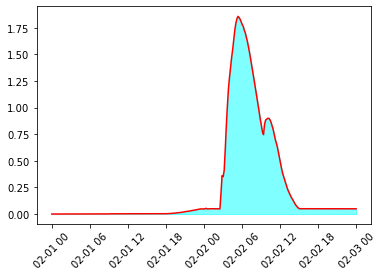

In [99]:
#h_vals = h_point
auc = trapz(h_processed, x=h_processed2.index)
plt.plot(h_processed2.index,h_point.values, color='red')

plt.fill_between(h_processed2.index,h_processed, alpha=0.5, color='cyan')

#plt.plot(h_vals, color='purple') #THIS IS JUST FOR VISUALIZATION
#plt.fill_between(h_vals.index,h_vals, alpha=0.5, color='cyan') #alplha is transparency. THIS IS JUST FOR VISUALIZATION

plt.xticks(rotation = 45) #ONLY IF YOU WANT ROTATED AXIS

print ('Area under the curve : ')
print (auc)